This notebook demonstrates fetching magnetic data, models, and residuals from VirES, and plotting them using cartopy. Requirements:
- `viresclient` (including pandas, xarray, cdflib etc.)
- `cartopy`

Some knowledge of `matplotlib`, `pandas`, `xarray`, `cartopy` is necessary

The notebook has several parts:

1. Fetching data residuals to a model
2. Fetching data and model values (and then calculating a residual locally)
3. Fetching residuals to a combined model directly
4. More complex combinations of models
5. Providing a custom .shc model
6. Using the orbit direction flags

---

# 1) Get B_NEC data at 10s sampling, residual to MCO_SHA_2C, for one day

Choose the `B_NEC` data and `MCO_SHA_2C` model, and request only the residuals (`B_NEC - B_NEC_MCO_SHA_2C`), at 10-second sampling. Fetch data from 1st January 2016, and load as an `xarray.Dataset`.

In [1]:
from viresclient import SwarmRequest
import datetime as dt

request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=["MCO_SHA_2C"],
    residuals=True,
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)

ds = data.as_xarray()
ds

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.497MB)


<xarray.Dataset>
Dimensions:               (Timestamp: 8640, dim: 3)
Coordinates:
  * Timestamp             (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-01T23:59:50
Dimensions without coordinates: dim
Data variables:
    Spacecraft            (Timestamp) <U1 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Latitude              (Timestamp) float64 -72.5 -73.13 -73.76 ... 30.46 31.1
    Longitude             (Timestamp) float64 92.79 93.09 ... -95.37 -95.37
    Radius                (Timestamp) float64 6.834e+06 6.834e+06 ... 6.823e+06
    B_NEC_res_MCO_SHA_2C  (Timestamp, dim) float64 -3.214 -184.3 ... -3.146 19.8
Attributes:
    Sources:         ['SW_OPER_MAGA_LR_1B_20160101T000000_20160101T235959_050...
    MagneticModels:  ['MCO_SHA_2C = MCO_SHA_2C(max_degree=18,min_degree=1)']
    RangeFilters:    []

## Use cartopy to plot the vertical component of the residual, over each polar region

Adapted from examples at https://scitools.org.uk/cartopy/docs/v0.15/gallery.html

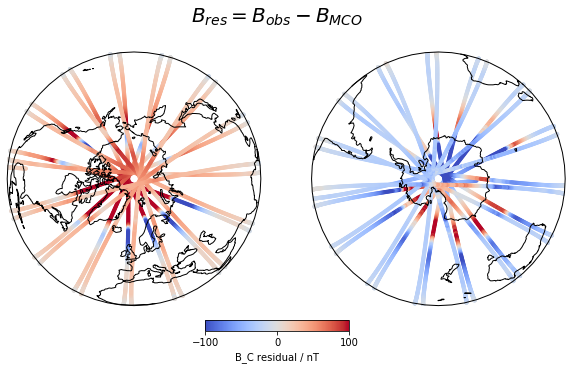

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
%matplotlib inline

def make_plot(ds, var, component="C", cmap=cm.coolwarm, norm=Normalize(vmin=-100,vmax=100)):
    component_to_idx = {"N":0, "E":1,"C": 2}

    fig = plt.figure(figsize=[10, 5])
    ax1 = plt.subplot(
        1, 2, 1,
        projection=ccrs.Orthographic(
            central_longitude=0.0, central_latitude=90.0
        )
    )
    ax2 = plt.subplot(
        1, 2, 2,
        projection=ccrs.Orthographic(
            central_longitude=0.0, central_latitude=-90.0
        )
    )

    def plot_hs(ax, ds):
        ax.scatter(
            ds.Longitude, ds.Latitude,
            c=ds[var][:,component_to_idx[component]],
            transform=ccrs.PlateCarree(),
            s=10, cmap=cmap, norm=norm
        )
        ax.set_global(); ax.coastlines()

    dsN = ds.where(ds["Latitude"] > 0)
    dsS = ds.where(ds["Latitude"] < 0)
    for ax, ds_subset in zip([ax1, ax2], [dsN, dsS]):
        plot_hs(ax, ds_subset)
    
    # cbar location [left, bottom, width, height] 
    ax_d = fig.add_axes([0.4,0.08,0.2,0.03]) 
    ColorbarBase(
        ax_d, cmap=cmap, norm=norm, orientation='horizontal',
        label="B_C residual / nT",
        ticks=[norm.vmin, (norm.vmax+norm.vmin)/2, norm.vmax]
    )

    return fig

fig = make_plot(ds, "B_NEC_res_MCO_SHA_2C")
fig.suptitle("$B_{res} = B_{obs} - B_{MCO}$", fontsize=20);

There is a hemispheric bias because we haven't accounted for the magnetospheric field

---

# 2) Redo the above, using the combination of (MCO,MMA)_SHA_2C

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.507MB)


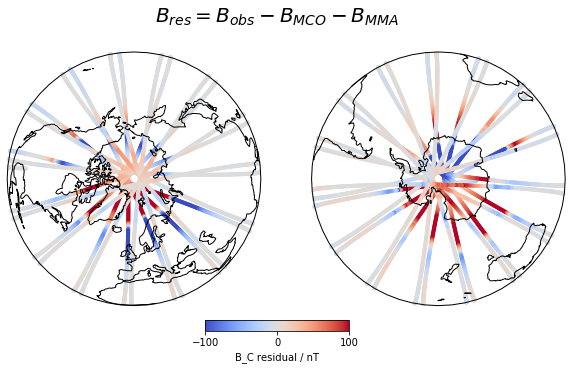

In [3]:
request = SwarmRequest()
request.set_collection("SW_OPER_MAGA_LR_1B")
request.set_products(
    measurements=["B_NEC"],
    models=[
        """
        'Model' = 'MCO_SHA_2C'
                + 'MMA_SHA_2C-Primary' + 'MMA_SHA_2C-Secondary'
        """
    ],
    residuals=True,
    auxiliaries=["QDOrbitDirection"],
    sampling_step="PT10S"
)

data = request.get_between(
    start_time=dt.datetime(2016,1,1),
    end_time=dt.datetime(2016,1,2)
)
ds = data.as_xarray()
ds

fig = make_plot(ds, "B_NEC_res_Model")
fig.suptitle("$B_{res} = B_{obs} - B_{MCO} - B_{MMA}$", fontsize=20);

# 3) Splitting by orbit direction flag

Filter by the orbit direction flag to visualise the data separately for each local time sector. 

- `OrbitDirection`:
    - +1 : ascending in latitude
    - -1 : descending in latitude
- `QDOrbitDirection`:
    - +1 : ascending in quasi-dipole latitude
    - -1 : descending in quasi-dipole latitude

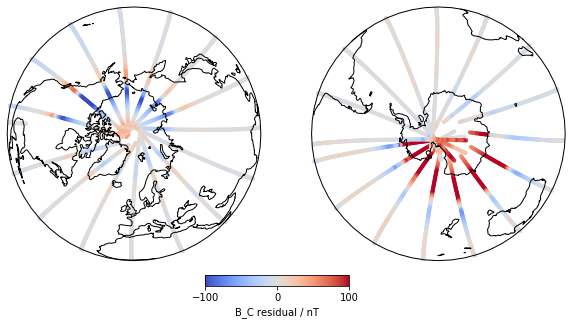

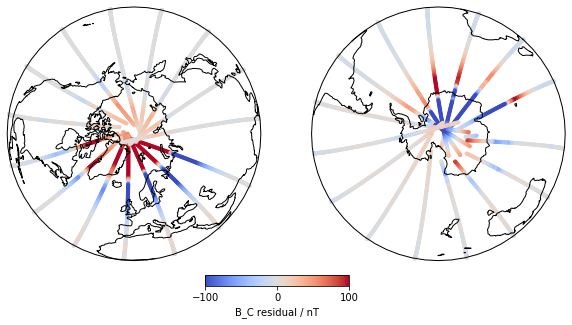

In [4]:
fig1 = make_plot(
    ds.where(ds["QDOrbitDirection"] == 1),
    "B_NEC_res_Model"
)

fig2 = make_plot(
    ds.where(ds["QDOrbitDirection"] == -1),
    "B_NEC_res_Model"
)